# Book Recommendation System 

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import surprise
from surprise import KNNBasic,accuracy
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt
import plotly.express as px
import re
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import warnings
warnings.filterwarnings('ignore')

# 1. Data Understanding

Reading book.csv

In [4]:
books=pd.read_csv("Books.csv")
books.head()

id  book_id  best_book_id  work_id  books_count       isbn        isbn13  \
0   1  2767052       2767052  2792775          272  439023483  9.780439e+12   
1   2        3             3  4640799          491  439554934  9.780440e+12   
2   3    41865         41865  3212258          226  316015849  9.780316e+12   
3   4     2657          2657  3275794          487   61120081  9.780061e+12   
4   5     4671          4671   245494         1356  743273567  9.780743e+12   

                       authors  original_publication_year  \
0              Suzanne Collins                     2008.0   
1  J.K. Rowling, Mary GrandPré                     1997.0   
2              Stephenie Meyer                     2005.0   
3                   Harper Lee                     1960.0   
4          F. Scott Fitzgerald                     1925.0   

                             original_title  ... ratings_count  \
0                          The Hunger Games  ...       4780653   
1  Harry Potter and the Philosopher's Stone  ...       4602479   
2                                  Twilight  ...       3866839   
3                     To Kill a Mockingbird  ...       3198671   
4                          The Great Gatsby  ...       2683664   

  work_ratings_count  work_text_reviews_count  ratings_1  ratings_2  \
0            4942365                   155254      66715     127936   
1            4800065                    75867      75504     101676   
2            3916824                    95009     456191     436802   
3            3340896                    72586      60427     117415   
4            2773745                    51992      86236     197621   

   ratings_3  ratings_4  ratings_5  \
0     560092    1481305    2706317   
1     455024    1156318    3011543   
2     793319     875073    1355439   
3     446835    1001952    1714267   
4     606158     936012     947718   

                                           image_url  \
0  https://images.gr-assets.com/books/1447303603m...   
1  https://images.gr-assets.com/books/1474154022m...   
2  https://images.gr-assets.com/books/1361039443m...   
3  https://images.gr-assets.com/books/1361975680m...   
4  https://images.gr-assets.com/books/1490528560m...   

                                     small_image_url  
0  https://images.gr-assets.com/books/1447303603s...  
1  https://images.gr-assets.com/books/1474154022s...  
2  https://images.gr-assets.com/books/1361039443s...  
3  https://images.gr-assets.com/books/1361975680s...  
4  https://images.gr-assets.com/books/1490528560s...  

[5 rows x 23 columns]

Reading rating.csv

In [5]:
ratings=pd.read_csv("ratings.csv")
ratings.head()

book_id  user_id  rating
0        1      314       5
1        1      439       3
2        1      588       5
3        1     1169       4
4        1     1185       4

Number of rows and columns in books dataset

In [6]:
books.shape

(10000, 23)

Number of rows and columns in ratings dataset

In [7]:
ratings.shape

(981756, 3)

Ratings sort by user_id

In [8]:
ratings=ratings.sort_values("user_id")
ratings.shape

(981756, 3)

In [9]:
ratings.head()

book_id  user_id  rating
117889     1180        1       4
488112     4893        1       3
625717     6285        1       4
796318     8034        2       4
875008     8855        2       5

Dropping duplicate values from ratings

In [10]:
ratings.drop_duplicates(subset =["user_id","book_id"], 
                     keep = False, inplace = True) 
ratings.shape

(977269, 3)

Displaying Unique author names 

In [11]:
books['authors'].unique()

array(['Suzanne Collins', 'J.K. Rowling, Mary GrandPré',
       'Stephenie Meyer', ..., 'Ian Mortimer', 'Peggy Orenstein',
       'John Keegan'], dtype=object)

Total count of unique author

In [12]:
len(books['authors'].unique())

4664

# Merging books and ratings dataset

In [13]:
mergedata = pd.merge(books,ratings,on=['book_id','book_id'])
mergedata.head(2)

id  book_id  best_book_id  work_id  books_count       isbn        isbn13  \
0   2        3             3  4640799          491  439554934  9.780440e+12   
1   2        3             3  4640799          491  439554934  9.780440e+12   

                       authors  original_publication_year  \
0  J.K. Rowling, Mary GrandPré                     1997.0   
1  J.K. Rowling, Mary GrandPré                     1997.0   

                             original_title  ... work_text_reviews_count  \
0  Harry Potter and the Philosopher's Stone  ...                   75867   
1  Harry Potter and the Philosopher's Stone  ...                   75867   

  ratings_1  ratings_2  ratings_3  ratings_4  ratings_5  \
0     75504     101676     455024    1156318    3011543   
1     75504     101676     455024    1156318    3011543   

                                           image_url  \
0  https://images.gr-assets.com/books/1474154022m...   
1  https://images.gr-assets.com/books/1474154022m...   

                                     small_image_url  user_id  rating  
0  https://images.gr-assets.com/books/1474154022s...      314       3  
1  https://images.gr-assets.com/books/1474154022s...      588       1  

[2 rows x 25 columns]

Names of all columns after merging in mergedata

In [14]:
mergedata.columns

Index(['id', 'book_id', 'best_book_id', 'work_id', 'books_count', 'isbn',
       'isbn13', 'authors', 'original_publication_year', 'original_title',
       'title', 'language_code', 'average_rating', 'ratings_count',
       'work_ratings_count', 'work_text_reviews_count', 'ratings_1',
       'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'image_url',
       'small_image_url', 'user_id', 'rating'],
      dtype='object')

Dropping unnecessary columns

In [15]:
book_data = mergedata.drop(columns=[ 'id','best_book_id', 'work_id',  'isbn13', 'title','work_ratings_count',
                                   'work_text_reviews_count', 
                               'image_url', 'language_code' ])

Renaming column names

In [16]:
book_data = book_data.rename({'rating':'userRating'}, axis='columns')
book_data = book_data.rename({'original_publication_year':'publication_year'}, axis='columns')
book_data = book_data.rename({'original_title':'title'}, axis='columns')
#book_data['publication_year']=book_data['publication_year'].astype(int)

Column names in book_data

In [17]:
book_data.columns

Index(['book_id', 'books_count', 'isbn', 'authors', 'publication_year',
       'title', 'average_rating', 'ratings_count', 'ratings_1', 'ratings_2',
       'ratings_3', 'ratings_4', 'ratings_5', 'small_image_url', 'user_id',
       'userRating'],
      dtype='object')

In [18]:
book_data = book_data.dropna()
book_data.head()

book_id  books_count       isbn                      authors  \
0        3          491  439554934  J.K. Rowling, Mary GrandPré   
1        3          491  439554934  J.K. Rowling, Mary GrandPré   
2        3          491  439554934  J.K. Rowling, Mary GrandPré   
3        3          491  439554934  J.K. Rowling, Mary GrandPré   
4        3          491  439554934  J.K. Rowling, Mary GrandPré   

   publication_year                                     title  average_rating  \
0            1997.0  Harry Potter and the Philosopher's Stone            4.44   
1            1997.0  Harry Potter and the Philosopher's Stone            4.44   
2            1997.0  Harry Potter and the Philosopher's Stone            4.44   
3            1997.0  Harry Potter and the Philosopher's Stone            4.44   
4            1997.0  Harry Potter and the Philosopher's Stone            4.44   

   ratings_count  ratings_1  ratings_2  ratings_3  ratings_4  ratings_5  \
0        4602479      75504     101676     455024    1156318    3011543   
1        4602479      75504     101676     455024    1156318    3011543   
2        4602479      75504     101676     455024    1156318    3011543   
3        4602479      75504     101676     455024    1156318    3011543   
4        4602479      75504     101676     455024    1156318    3011543   

                                     small_image_url  user_id  userRating  
0  https://images.gr-assets.com/books/1474154022s...      314           3  
1  https://images.gr-assets.com/books/1474154022s...      588           1  
2  https://images.gr-assets.com/books/1474154022s...     2077           2  
3  https://images.gr-assets.com/books/1474154022s...     2487           3  
4  https://images.gr-assets.com/books/1474154022s...     2900           3

In [19]:
book_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76619 entries, 0 to 79362
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   book_id           76619 non-null  int64  
 1   books_count       76619 non-null  int64  
 2   isbn              76619 non-null  object 
 3   authors           76619 non-null  object 
 4   publication_year  76619 non-null  float64
 5   title             76619 non-null  object 
 6   average_rating    76619 non-null  float64
 7   ratings_count     76619 non-null  int64  
 8   ratings_1         76619 non-null  int64  
 9   ratings_2         76619 non-null  int64  
 10  ratings_3         76619 non-null  int64  
 11  ratings_4         76619 non-null  int64  
 12  ratings_5         76619 non-null  int64  
 13  small_image_url   76619 non-null  object 
 14  user_id           76619 non-null  int64  
 15  userRating        76619 non-null  int64  
dtypes: float64(2), int64(10), object(4)
memo

Total number of NA values in each column

In [20]:
book_data.isna().sum()

book_id             0
books_count         0
isbn                0
authors             0
publication_year    0
title               0
average_rating      0
ratings_count       0
ratings_1           0
ratings_2           0
ratings_3           0
ratings_4           0
ratings_5           0
small_image_url     0
user_id             0
userRating          0
dtype: int64

# Duplicates

As many authors writing same books many years. 

In this case all columns have the same value for such 'duplicate' books except for the year. Especially the number of reviews and the user rating represent the total number over all years.


In the following, we will work with a dataframe of unique book_data unless otherwise stated. In case of duplicates the book is assigned to the first year it has been a displayed.

By using 'last', the last occurrence of each set of duplicated values is set on False and all others on True. By setting keep on False, all duplicates are True. To find duplicates on specific column(s), use subset .

In [21]:
book_data[book_data.duplicated(subset=['authors','title'], keep=False)].sort_values('title')

book_id  books_count        isbn                         authors  \
70398     9549           27   553574132                     Steve Perry   
70326     9549           27   553574132                     Steve Perry   
70327     9549           27   553574132                     Steve Perry   
70328     9549           27   553574132                     Steve Perry   
70329     9549           27   553574132                     Steve Perry   
...        ...          ...         ...                             ...   
21693      870           37  1591169208  Hiromu Arakawa, Akira Watanabe   
21692      870           37  1591169208  Hiromu Arakawa, Akira Watanabe   
21691      870           37  1591169208  Hiromu Arakawa, Akira Watanabe   
21738      870           37  1591169208  Hiromu Arakawa, Akira Watanabe   
21654      870           37  1591169208  Hiromu Arakawa, Akira Watanabe   

       publication_year     title  average_rating  ratings_count  ratings_1  \
70398            1996.0                      3.81          12927        185   
70326            1996.0                      3.81          12927        185   
70327            1996.0                      3.81          12927        185   
70328            1996.0                      3.81          12927        185   
70329            1996.0                      3.81          12927        185   
...                 ...       ...             ...            ...        ...   
21693            2002.0  鋼の錬金術師 1            4.49          93990        972   
21692            2002.0  鋼の錬金術師 1            4.49          93990        972   
21691            2002.0  鋼の錬金術師 1            4.49          93990        972   
21738            2002.0  鋼の錬金術師 1            4.49          93990        972   
21654            2002.0  鋼の錬金術師 1            4.49          93990        972   

       ratings_2  ratings_3  ratings_4  ratings_5  \
70398        927       3880       5001       3695   
70326        927       3880       5001       3695   
70327        927       3880       5001       3695   
70328        927       3880       5001       3695   
70329        927       3880       5001       3695   
...          ...        ...        ...        ...   
21693       1734       8737      21751      61574   
21692       1734       8737      21751      61574   
21691       1734       8737      21751      61574   
21738       1734       8737      21751      61574   
21654       1734       8737      21751      61574   

                                         small_image_url  user_id  userRating  
70398  https://images.gr-assets.com/books/1361481442s...    46784           5  
70326  https://images.gr-assets.com/books/1361481442s...     8938           4  
70327  https://images.gr-assets.com/books/1361481442s...     8980           5  
70328  https://images.gr-assets.com/books/1361481442s...     9020           5  
70329  https://images.gr-assets.com/books/1361481442s...    11515           4  
...                                                  ...      ...         ...  
21693  https://s.gr-assets.com/assets/nophoto/book/50...    18480           5  
21692  https://s.gr-assets.com/assets/nophoto/book/50...    16330           2  
21691  https://s.gr-assets.com/assets/nophoto/book/50...    16192           4  
21738  https://s.gr-assets.com/assets/nophoto/book/50...    44909           4  
21654  https://s.gr-assets.com/assets/nophoto/book/50...      343           5  

[76619 rows x 16 columns]

In [22]:
# Build a second dataframe with unique book_data.
unique_book_data = book_data.drop_duplicates(subset=['authors','title'])

In [23]:
unique_book_data.head()

book_id  books_count       isbn                      authors  \
0          3          491  439554934  J.K. Rowling, Mary GrandPré   
100     2657          487   61120081                   Harper Lee   
200     4671         1356  743273567          F. Scott Fitzgerald   
300     5907          969  618260307               J.R.R. Tolkien   
400     5107          360  316769177                J.D. Salinger   

     publication_year                                     title  \
0              1997.0  Harry Potter and the Philosopher's Stone   
100            1960.0                     To Kill a Mockingbird   
200            1925.0                          The Great Gatsby   
300            1937.0        The Hobbit or There and Back Again   
400            1951.0                    The Catcher in the Rye   

     average_rating  ratings_count  ratings_1  ratings_2  ratings_3  \
0              4.44        4602479      75504     101676     455024   
100            4.25        3198671      60427     117415     446835   
200            3.89        2683664      86236     197621     606158   
300            4.25        2071616      46023      76784     288649   
400            3.79        2044241     109383     185520     455042   

     ratings_4  ratings_5                                    small_image_url  \
0      1156318    3011543  https://images.gr-assets.com/books/1474154022s...   
100    1001952    1714267  https://images.gr-assets.com/books/1361975680s...   
200     936012     947718  https://images.gr-assets.com/books/1490528560s...   
300     665635    1119718  https://images.gr-assets.com/books/1372847500s...   
400     661516     709176  https://images.gr-assets.com/books/1398034300s...   

     user_id  userRating  
0        314           3  
100      324           4  
200      206           3  
300       10           4  
400     1140           5

In [24]:
unique_book_data.shape

(784, 16)

# Finding User's favorite books

# Mean rating per user

In [25]:
MRPU = ratings.groupby(['user_id']).mean().reset_index()
MRPU['mean_rating'] = MRPU['rating']

MRPU.drop(['book_id','rating'],axis=1, inplace=True)

In [26]:
MRPU.head()

user_id  mean_rating
0        1     3.666667
1        2     4.333333
2        3     1.000000
3        4     4.000000
4        5     4.200000

In [27]:
rating_data = pd.merge(ratings, MRPU, on=['user_id', 'user_id'])
rating_data.head()

book_id  user_id  rating  mean_rating
0     1180        1       4     3.666667
1     4893        1       3     3.666667
2     6285        1       4     3.666667
3     8034        2       4     4.333333
4     8855        2       5     4.333333

For finding each users favourite books based on their rating we have dropped the rows which are having less ratings than their mean rating calculated before.

So from this we can see the each users favourite books.

In [28]:
rating_data = rating_data.drop(rating_data[rating_data.rating < rating_data.mean_rating].index)

In [29]:
# user1's favorite books

rating_data[rating_data['user_id']== 1].head()

book_id  user_id  rating  mean_rating
0     1180        1       4     3.666667
2     6285        1       4     3.666667

In [30]:
# user2's favorite book
rating_data[rating_data['user_id']== 2].head()

book_id  user_id  rating  mean_rating
4     8855        2       5     4.333333

In [31]:
# user5's favorite book

rating_data[rating_data['user_id']== 5].head()

book_id  user_id  rating  mean_rating
11     8072        5       5          4.2
13     7487        5       5          4.2

# Distributions

<AxesSubplot:>

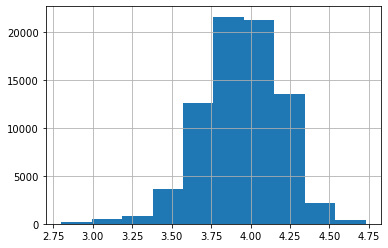

In [32]:
 book_data.average_rating.hist()

From above visualization we can see that average rating is mostly between 3.5 to 4.5

# 2. Data Visualization

# Top 10 rated books

In [33]:
top_rated=books.sort_values('average_rating', ascending=False)
top10=top_rated.head(10)
f=['title','small_image_url']
displ=(top10[f])
displ.set_index('title', inplace=True)

In [34]:
from IPython.display import Image, HTML

def path_to_image_html(path):
    '''
     This function essentially convert the image url to 
     '<img src="'+ path + '"/>' format. And one can put any
     formatting adjustments to control the height, aspect ratio, size etc.
     within as in the below example. 
    '''

    return '<img src="'+ path + '""/>'

HTML(displ.to_html(escape=False ,formatters=dict(small_image_url=path_to_image_html),justify='center'))

# Top 10 most popular books

In [35]:
pop10=books.sort_values(by='ratings_count', ascending=False)
f=['title','small_image_url']
pop10=pop10.head(10)

pop10=(pop10[f])
pop10=pop10.set_index('title')


In [36]:
HTML(pop10.to_html(escape=False ,formatters=dict(small_image_url=path_to_image_html),justify='center'))

# Most Common Rating Values

<AxesSubplot:xlabel='average_rating', ylabel='Density'>

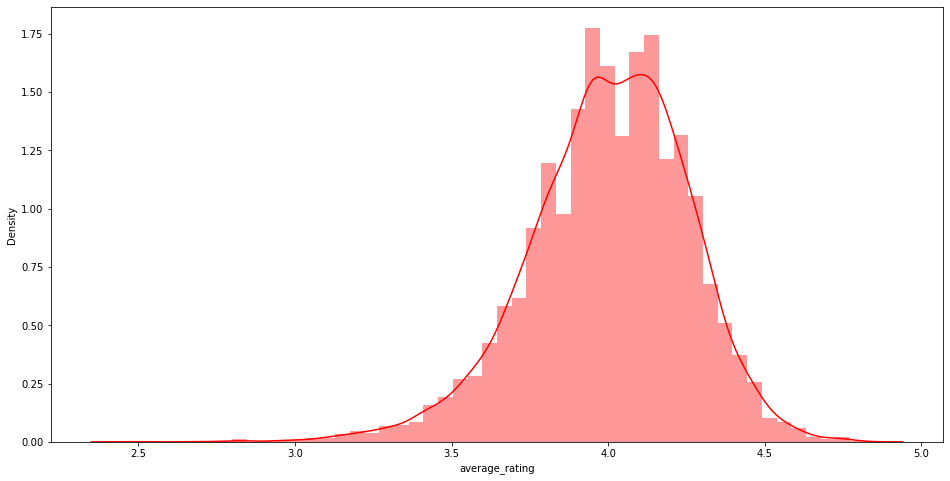

In [37]:
import seaborn as sns
plt.figure(figsize=(16,8))
sns.distplot(a=books['average_rating'], kde=True, color='r')

Therefore, the most common rating is somewhere between 3.5 to 4.

# Highly rated authors

In [38]:
f=['authors', 'average_rating']
top_authors=top_rated[f]
top_authors=top_authors.head(20)

In [39]:
fig = px.bar(top_authors, x='authors', y='average_rating', color ='average_rating')
fig.show()

Above barplot shows the top rated authors. Bill Waterson is on the top with a whopping rating of 4.82!

# Top author frequency of the book

In [40]:
top_author_counts = books['authors'].value_counts().reset_index()
top_author_counts.columns = ['value', 'count']
top_author_counts['value'] = top_author_counts['value']
top_author_counts = top_author_counts.sort_values('count')
fig = px.bar(top_author_counts.tail(50), x="count", y="value", title='Top Authors', orientation='h', color='value',
             width=1000, height=700)
fig.show()

In [41]:
#change some features' name.
data1= books.head(20)
data1.rename(columns={'ratings_1':'R1', 'ratings_2':'R2','ratings_3':'R3','ratings_4':'R4','ratings_5':'R5'}, inplace=True)

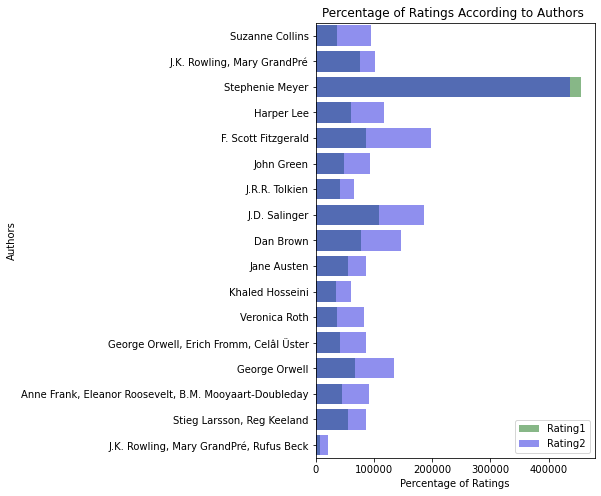

In [42]:
# Percentage of Ratings According to Authors
author_list= list(data1['authors'].unique())

ratings1= []
ratings2= []
for i in author_list:
    
    x = data1[data1['authors']==i]
    ratings1.append(sum(x.R1)/len(x))
    ratings2.append(sum(x.R2)/len(x))
    
f,ax = plt.subplots(figsize = (5,8))
sns.barplot(x=ratings1,y=author_list,color='green',alpha = 0.5,label='Rating1' )
sns.barplot(x=ratings2,y=author_list,color='blue',alpha = 0.5,label='Rating2' )
ax.legend(loc='lower right',frameon = True)   
ax.set(xlabel='Percentage of Ratings', ylabel='Authors',title = "Percentage of Ratings According to Authors ")
plt.show()

# WordCloud of Author names

In [43]:
from wordcloud import WordCloud,STOPWORDS
stop_words=set(STOPWORDS)
authors_string = " ".join(book_data['authors'])
wc = WordCloud(width=800,height=500,mask=None,random_state=21, max_font_size=110,stopwords=stop_words).generate(authors_string)

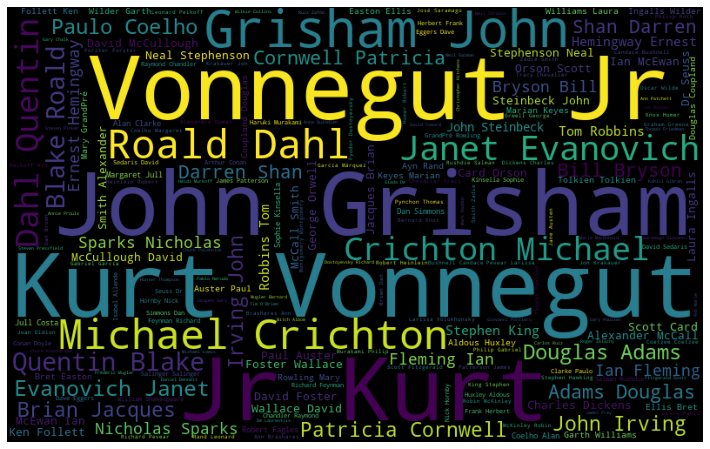

In [44]:
fig=plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(wc)

# WordCloud of Title of the books

In [45]:
stop_words=set(STOPWORDS)
title_string = " ".join(book_data['title'])
wc = WordCloud(width=800,height=500,mask=None,random_state=21, max_font_size=110,stopwords=stop_words).generate(title_string)

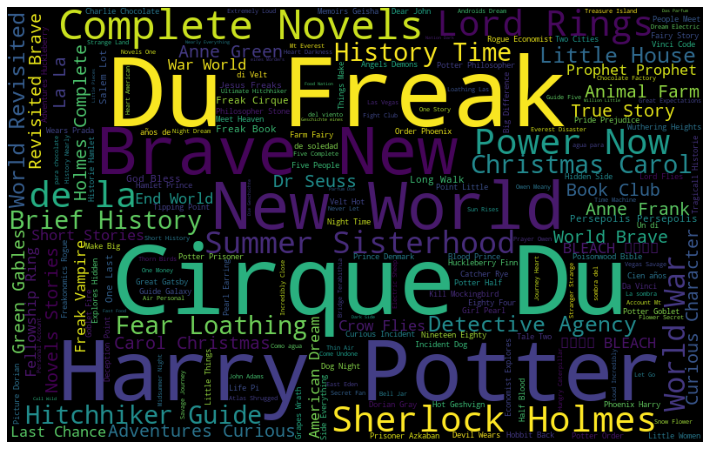

In [46]:
fig=plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(wc)

In [47]:
books = books.dropna()

# 3. Content based recommondation

This method uses attributes of the content to recommend similar content. It doesn’t have a cold-start problem because it works through attributes or tags of the content, such as book title, authors or rating, so that new book can be recommended right away.

In [48]:
content_data = books[['title','authors','average_rating']]
content_data = content_data.astype(str)

In [49]:
content_data['content'] = content_data['title'] + ' ' + content_data['authors'] + ' ' + content_data['average_rating']

In [50]:
content_data = content_data.reset_index()
indices = pd.Series(content_data.index, index=content_data['title'])
indices

title
The Hunger Games (The Hunger Games, #1)                                                         0
Harry Potter and the Sorcerer's Stone (Harry Potter, #1)                                        1
Twilight (Twilight, #1)                                                                         2
To Kill a Mockingbird                                                                           3
The Great Gatsby                                                                                4
                                                                                             ... 
Billy Budd, Sailor                                                                           7855
Bayou Moon (The Edge, #2)                                                                    7856
Means of Ascent (The Years of Lyndon Johnson, #2)                                            7857
The Mauritius Command                                                                        7858
Cinderella Ate

# 3.1 Content based recommodation author

In [51]:
#removing stopwords
tfidf = TfidfVectorizer(stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(content_data['authors'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(7860, 5281)

The advantage of TF-IDF encoding is that it will weigh a term (a tag for a book in our example) according to the importance of the term within the document: The more frequently the term appears, the larger its weight will be. At the same time, it weighs the item inversely to the frequency of this term across the entire dataset: It will emphasise terms that are relatively rare occurrences in the general dataset but of importance to the specific content at hand. That means that words such as ‘is’, ‘are’, ‘by’ or ‘a’ which are likely to show up in every book content but aren’t useful for our user-recommendation, will be weighed less than words that are more unique to the content that we are recommending.

Compute the cosine similarity matrix

We are going to use a simple similarity-based method called cosine similarity

In [52]:
cosine_sim_author = linear_kernel(tfidf_matrix, tfidf_matrix)

# Author wise recommodation

In [53]:
def get_recommendations_books(title, cosine_sim=cosine_sim_author):
    idx = indices[title]

    # Get the pairwsie similarity scores of all books with that book
    sim_scores = list(enumerate(cosine_sim_author[idx]))

    # Sort the books based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar books
    sim_scores = sim_scores[1:11]

    # Get the book indices
    book_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar books
    return list(content_data['title'].iloc[book_indices])

In [54]:
def author_book_shows(book):
    for book in book:
        print(book)

In [55]:
books1 = get_recommendations_books('The Hobbit', cosine_sim_author)
author_book_shows(books1)

The Fellowship of the Ring (The Lord of the Rings, #1)
The Two Towers (The Lord of the Rings, #2)
The Return of the King (The Lord of the Rings, #3)
The Lord of the Rings (The Lord of the Rings, #1-3)
J.R.R. Tolkien 4-Book Boxed Set: The Hobbit and The Lord of the Rings
The Children of Húrin
The Silmarillion (Middle-Earth Universe)
The History of the Hobbit, Part One: Mr. Baggins
The Hobbit: Graphic Novel
The Hunger Games (The Hunger Games, #1)


In [56]:
books2 =get_recommendations_books('To Kill a Mockingbird', cosine_sim_author)
author_book_shows(books2)

Go Set a Watchman
The Last Boleyn
Nice Girls Don't Have Fangs (Jane Jameson, #1)
Killing Floor (Jack Reacher, #1)
One Shot (Jack Reacher, #9)
Die Trying (Jack Reacher, #2)
Tripwire  (Jack Reacher, #3)
Worth Dying For (Jack Reacher, #15)
Running Blind (Jack Reacher, #4)
The Affair (Jack Reacher, #16)


In [57]:
books3 =get_recommendations_books('The Great Gatsby', cosine_sim_author)
author_book_shows(books3)

Tender Is the Night
This Side of Paradise
The Curious Case of Benjamin Button
The Short Stories
The Aeneid
The Great Brain (Great Brain #1)
The Alchemyst (The Secrets of the Immortal Nicholas Flamel, #1)
The Magician (The Secrets of the Immortal Nicholas Flamel, #2)
The Sorceress (The Secrets of the Immortal Nicholas Flamel, #3)
The Necromancer  (The Secrets of the Immortal Nicholas Flamel, #4)


# 4. Colloaborative Recommendation

In [58]:
books=pd.read_csv("Books.csv")
ratings=pd.read_csv('ratings.csv')
train=pd.merge(books,ratings)
train.head()

id  book_id  best_book_id  work_id  books_count       isbn        isbn13  \
0   2        3             3  4640799          491  439554934  9.780440e+12   
1   2        3             3  4640799          491  439554934  9.780440e+12   
2   2        3             3  4640799          491  439554934  9.780440e+12   
3   2        3             3  4640799          491  439554934  9.780440e+12   
4   2        3             3  4640799          491  439554934  9.780440e+12   

                       authors  original_publication_year  \
0  J.K. Rowling, Mary GrandPré                     1997.0   
1  J.K. Rowling, Mary GrandPré                     1997.0   
2  J.K. Rowling, Mary GrandPré                     1997.0   
3  J.K. Rowling, Mary GrandPré                     1997.0   
4  J.K. Rowling, Mary GrandPré                     1997.0   

                             original_title  ... work_text_reviews_count  \
0  Harry Potter and the Philosopher's Stone  ...                   75867   
1  Harry Potter and the Philosopher's Stone  ...                   75867   
2  Harry Potter and the Philosopher's Stone  ...                   75867   
3  Harry Potter and the Philosopher's Stone  ...                   75867   
4  Harry Potter and the Philosopher's Stone  ...                   75867   

  ratings_1  ratings_2  ratings_3  ratings_4  ratings_5  \
0     75504     101676     455024    1156318    3011543   
1     75504     101676     455024    1156318    3011543   
2     75504     101676     455024    1156318    3011543   
3     75504     101676     455024    1156318    3011543   
4     75504     101676     455024    1156318    3011543   

                                           image_url  \
0  https://images.gr-assets.com/books/1474154022m...   
1  https://images.gr-assets.com/books/1474154022m...   
2  https://images.gr-assets.com/books/1474154022m...   
3  https://images.gr-assets.com/books/1474154022m...   
4  https://images.gr-assets.com/books/1474154022m...   

                                     small_image_url  user_id  rating  
0  https://images.gr-assets.com/books/1474154022s...      314       3  
1  https://images.gr-assets.com/books/1474154022s...      588       1  
2  https://images.gr-assets.com/books/1474154022s...     2077       2  
3  https://images.gr-assets.com/books/1474154022s...     2487       3  
4  https://images.gr-assets.com/books/1474154022s...     2900       3  

[5 rows x 25 columns]

In [59]:
userRatings = train.pivot_table(index=['user_id'],columns=['title'],values='rating')
userRatings.head()

title    'Salem's Lot  'Tis (Frank McCourt, #2)  \
user_id                                           
2                 NaN                       NaN   
3                 NaN                       NaN   
4                 NaN                       NaN   
7                 NaN                       NaN   
9                 NaN                       NaN   

title    1421: The Year China Discovered America  1776  1984  \
user_id                                                        
2                                            NaN   NaN   NaN   
3                                            NaN   NaN   NaN   
4                                            NaN   NaN   NaN   
7                                            NaN   NaN   NaN   
9                                            NaN   NaN   NaN   

title    A Bend in the River  A Bend in the Road  A Brief History of Time  \
user_id                                                                     
2                        NaN                 NaN                      NaN   
3                        NaN                 NaN                      NaN   
4                        NaN                 NaN                      NaN   
7                        NaN                 NaN                      NaN   
9                        NaN                 NaN                      NaN   

title    A Briefer History of Time  A Case of Need  ...  \
user_id                                             ...   
2                              NaN             NaN  ...   
3                              NaN             NaN  ...   
4                              NaN             NaN  ...   
7                              NaN             NaN  ...   
9                              NaN             NaN  ...   

title    Women in Love (Brangwen Family, #2)  \
user_id                                        
2                                        NaN   
3                                        NaN   
4                                        NaN   
7                                        NaN   
9                                        NaN   

title    World War Z: An Oral History of the Zombie War  \
user_id                                                   
2                                                   NaN   
3                                                   NaN   
4                                                   NaN   
7                                                   NaN   
9                                                   NaN   

title    World Without End (The Kingsbridge Series, #2)  Wuthering Heights  \
user_id                                                                      
2                                                   NaN                NaN   
3                                                   NaN                NaN   
4                                                   NaN                NaN   
7                                                   NaN                NaN   
9                                                   NaN                NaN   

title    Xenocide (Ender's Saga, #3)  Year of Wonders  \
user_id                                                 
2                                NaN              NaN   
3                                NaN              NaN   
4                                NaN              NaN   
7                                NaN              NaN   
9                                NaN              NaN   

title    You Shall Know Our Velocity!  \
user_id                                 
2                                 NaN   
3                                 NaN   
4                                 NaN   
7                                 NaN   
9                                 NaN   

title    Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values  \
user_id                                                                      
2                                                      NaN                   
3                  

In [60]:
userRatings=userRatings.dropna(thresh=10,axis=1).fillna(0)
#Here we are removing the book having less than 10 user ratings and replacing NaN values with 0.
userRatings.head()

title    'Salem's Lot  'Tis (Frank McCourt, #2)  \
user_id                                           
2                 0.0                       0.0   
3                 0.0                       0.0   
4                 0.0                       0.0   
7                 0.0                       0.0   
9                 0.0                       0.0   

title    1421: The Year China Discovered America  1776  1984  \
user_id                                                        
2                                            0.0   0.0   0.0   
3                                            0.0   0.0   0.0   
4                                            0.0   0.0   0.0   
7                                            0.0   0.0   0.0   
9                                            0.0   0.0   0.0   

title    A Bend in the River  A Bend in the Road  A Brief History of Time  \
user_id                                                                     
2                        0.0                 0.0                      0.0   
3                        0.0                 0.0                      0.0   
4                        0.0                 0.0                      0.0   
7                        0.0                 0.0                      0.0   
9                        0.0                 0.0                      0.0   

title    A Briefer History of Time  A Case of Need  ...  \
user_id                                             ...   
2                              0.0             0.0  ...   
3                              0.0             0.0  ...   
4                              0.0             0.0  ...   
7                              0.0             0.0  ...   
9                              0.0             0.0  ...   

title    Women in Love (Brangwen Family, #2)  \
user_id                                        
2                                        0.0   
3                                        0.0   
4                                        0.0   
7                                        0.0   
9                                        0.0   

title    World War Z: An Oral History of the Zombie War  \
user_id                                                   
2                                                   0.0   
3                                                   0.0   
4                                                   0.0   
7                                                   0.0   
9                                                   0.0   

title    World Without End (The Kingsbridge Series, #2)  Wuthering Heights  \
user_id                                                                      
2                                                   0.0                0.0   
3                                                   0.0                0.0   
4                                                   0.0                0.0   
7                                                   0.0                0.0   
9                                                   0.0                0.0   

title    Xenocide (Ender's Saga, #3)  Year of Wonders  \
user_id                                                 
2                                0.0              0.0   
3                                0.0              0.0   
4                                0.0              0.0   
7                                0.0              0.0   
9                                0.0              0.0   

title    You Shall Know Our Velocity!  \
user_id                                 
2                                 0.0   
3                                 0.0   
4                                 0.0   
7                                 0.0   
9                                 0.0   

title    Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values  \
user_id                                                                      
2                                                      0.0                   
3                  

In [61]:
books=userRatings.columns
books

Index([''Salem's Lot', ''Tis (Frank McCourt, #2)',
       '1421: The Year China Discovered America', '1776', '1984',
       'A Bend in the River', 'A Bend in the Road', 'A Brief History of Time',
       'A Briefer History of Time', 'A Case of Need',
       ...
       'Women in Love (Brangwen Family, #2)',
       'World War Z: An Oral History of the Zombie War',
       'World Without End (The Kingsbridge Series, #2)', 'Wuthering Heights',
       'Xenocide (Ender's Saga, #3)', 'Year of Wonders',
       'You Shall Know Our Velocity!',
       'Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values',
       'Zodiac', 'number9dream'],
      dtype='object', name='title', length=812)

In [62]:
item_similarity_pearson=userRatings.corr(method='pearson')
item_similarity_pearson.head()

title                                    'Salem's Lot  \
title                                                   
'Salem's Lot                                 1.000000   
'Tis (Frank McCourt, #2)                    -0.002777   
1421: The Year China Discovered America     -0.002759   
1776                                        -0.002790   
1984                                        -0.002741   

title                                    'Tis (Frank McCourt, #2)  \
title                                                               
'Salem's Lot                                            -0.002777   
'Tis (Frank McCourt, #2)                                 1.000000   
1421: The Year China Discovered America                  0.017751   
1776                                                     0.005980   
1984                                                    -0.003238   

title                                    1421: The Year China Discovered America  \
title                                                                              
'Salem's Lot                                                           -0.002759   
'Tis (Frank McCourt, #2)                                                0.017751   
1421: The Year China Discovered America                                 1.000000   
1776                                                                    0.051997   
1984                                                                   -0.003217   

title                                        1776      1984  \
title                                                         
'Salem's Lot                            -0.002790 -0.002741   
'Tis (Frank McCourt, #2)                 0.005980 -0.003238   
1421: The Year China Discovered America  0.051997 -0.003217   
1776                                     1.000000 -0.003253   
1984                                    -0.003253  1.000000   

title                                    A Bend in the River  \
title                                                          
'Salem's Lot                                       -0.002700   
'Tis (Frank McCourt, #2)                           -0.003189   
1421: The Year China Discovered America            -0.003168   
1776                                               -0.003204   
1984                                               -0.003148   

title                                    A Bend in the Road  \
title                                                         
'Salem's Lot                                      -0.002803   
'Tis (Frank McCourt, #2)                          -0.003311   
1421: The Year China Discovered America           -0.003290   
1776                                              -0.003327   
1984                                              -0.003269   

title                                    A Brief History of Time  \
title                                                              
'Salem's Lot                                           -0.002744   
'Tis (Frank McCourt, #2)                               -0.003241   
1421: The Year China Discovered America                -0.003220   
1776                                                   -0.003257   
1984                                                   -0.003200   

title                                    A Briefer History of Time  \
title                                                                
'Salem's Lot                                             -0.002784   
'Tis (Frank McCourt, #2)                                 -0.003289   
1421: The Year China Discovered America                   0.026612   
1776                                                      0.481489   
1984                                                     -0.003247   

title                                    A Case of Need  ...  \
title                                                    ...   
'Salem's Lot                                  -0.002641  ...   
'Tis (Frank McCourt, #2)          

In [63]:
ratings=ratings[['user_id','book_id','rating']] 
ratings = ratings.iloc[:20000,:]
reader = surprise.Reader(rating_scale=(1,5)) 
dataset1 = surprise.Dataset.load_from_df(ratings, reader)

In [64]:
train1,test1 = train_test_split(dataset1,test_size=0.2)

# User Based

In [65]:
user_model = surprise.KNNBasic(k=40,sim_options={'name': 'pearson','user_based': True})
user_model.fit(train1)
preds = user_model.test(test1)
accuracy.rmse(preds,verbose=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0208


1.020810230105658

In [66]:
user1=[("1421: The Year China Discovered America",4.0),
       ("A House for Mr Biswas",5.0),
       ("A History of God: The 4,000-Year Quest of Judaism, Christianity, and Islam",1.0)
      ]
user1=zip(books,userRatings.iloc[0,:])

In [67]:
def get_similar_books_pearson_user(book_name,user_rating):
    similar_score=item_similarity_pearson[book_name]*(user_rating-2.5)
    similar_score=similar_score.sort_values(ascending=False)
    return similar_score

In [68]:
print("Using Pearson")
similar_books=pd.DataFrame()
for book,rating in user1:
    similar_books=similar_books.append(get_similar_books_pearson_user(book,rating),ignore_index=True)
recommended_pearson=similar_books.sum().sort_values(ascending=False).index

Using Pearson


In [69]:
print("User-based Collabrative Filtering (Pearson)\n Recommendations for user_id 2")
print("\n\n")
for ind in recommended_pearson[:10]:
    print(ind)

User-based Collabrative Filtering (Pearson)
 Recommendations for user_id 2



Loving What Is: Four Questions That Can Change Your Life
Lucy Sullivan Is Getting Married
Haroun and the Sea of Stories (Khalifa Brothers, #1)
Tears of the Giraffe (No. 1 Ladies' Detective Agency, #2)
The Idiot Girls' Action-Adventure Club: True Tales from a Magnificent and Clumsy Life
Freak the Mighty (Freak The Mighty, #1)
Genome: the Autobiography of a Species in 23 Chapters
Deadeye Dick
Next
How to Stop Worrying and Start Living


# Item based

In [70]:
item_model = surprise.KNNBasic(k=40,sim_options={'name': 'pearson','user_based': False})

In [71]:
item_model.fit(train1)
preds = item_model.test(test1)
print("Item-based KNN Model Accuracy : ",accuracy.rmse(preds,verbose=True)*100)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9523
Item-based KNN Model Accuracy :  95.2298986894441


In [72]:
def get_similar_books_pearson_itemtoitem(bookname):
    similar_score=item_similarity_pearson[bookname]*(2.5)
    similar_score=similar_score.sort_values(ascending=False)
    return similar_score

In [73]:
book_name=books[3]
recommended_pearson_item=get_similar_books_pearson_itemtoitem(book_name).index

In [74]:
print("Item based Collabrative Filtering for book",book_name,"\n\n")
for ind in recommended_pearson_item[1:11]:
    print(ind)

Item based Collabrative Filtering for book 1776 


The Shadow of the Wind (The Cemetery of Forgotten Books,  #1)
Brokeback Mountain
A Briefer History of Time
The Five Love Languages of Children
The Sun Also Rises
Quicksilver (The Baroque Cycle, #1)
The Prophet
Warrior of the Light
The Westing Game
Confessions of an Economic Hit Man
